# Replicating Faber _et al._
Use the representation developed by Faber _et al._ to predict stability given a dataset of all the same kinds of elements

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pymatgen import Element, Composition
from pymatgen.io.vasp.outputs import Poscar
from sklearn.base import RegressorMixin
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
import pandas as pd
import numpy as np
import os
import re
import itertools
import json

In [2]:
train_sizes = [1,10,100,1000]
test_size = 20000
n_repeats = 25
pick_size = 50

## Load in the QH dataset
Load in the QH data, and convert stability where missing

In [3]:
def load_data(path):
    """Read in a JSON file from disk, and return a DataFrame with poscar and class"""
    
    temp = json.load(open(path))
    data = pd.DataFrame([x['poscar'] for x in temp['entries']], columns=['poscar'])
    data['class'] = [x['class']['measured'] for x in temp['entries']]
    data = data[~data['class'].isnull()]
    return data
qh_data = load_data(os.path.join('..', 'datasets', 'quat-heuslers.json'))

## Load in list of elements and compositions
The representation for Faber's method relies on knowing which element sits on each site. In this section, we match the sites in a POSCAR (which may be in a random order) to a standard order, and then determine which element sits on each site

In [4]:
ere = re.compile("[A-Z][a-z]?")

In [5]:
def get_element_tuple(poscar):
    # Load in the poscar
    try:
        pos = Poscar.from_string(poscar)
    except:
        raise
        #return np.array([Element(x) for x in ere.findall(filename.split("-")[-1])])
    
    # Get the atoms in sites in the order
    #   [0, 0, 0], [0.25, 0.25, 0.25], [0.5, 0.5, 0.5], [0.75, 0.75, 0.75]
    elems = [None,] * 4
    for atom in pos.structure:
        elems[(int(round(atom.frac_coords[0] * 4))) % 4] = atom.specie
    
    if any([e is None for e in elems]):
        raise Exception('Atom not matched')
    return np.array(elems)

In [6]:
%%time
qh_data['elems'] = qh_data['poscar'].apply(get_element_tuple)

CPU times: user 26.3 s, sys: 12 ms, total: 26.3 s
Wall time: 26.3 s


Eliminate entries with 3 elements

In [7]:
qh_data['nelems'] = [len(x) for x in qh_data['elems']]

In [8]:
qh_data.query('nelems == 4', inplace=True)

Get list of all the elements

In [9]:
qh_elements = list(set(sum([x.tolist() for x in qh_data['elems'] if x is not None], [])))
print('%d elements in space'%len(qh_elements))

54 elements in space


Save data for later use (by the DMSP script)

In [10]:
with open('qh-training-set.list', 'w') as fp:
    print('comp', 'stable{True,False}', file=fp)
    for rid, row in qh_data.iterrows():
        print(''.join([e.symbol for e in row['elems']]), row['class'] <= 0, file=fp)

## Create code for measuring "distance" between entries
Faber represents each electrons by a tuple where composed of the row and column number of each site. 

In [11]:
def compute_representation(elems):
    return [e.row for e in elems] + [e.group for e in elems]
assert compute_representation([Element('Al')]) == [3, 13]

For Faber's work on Elpasolite, each unique structure has exactly one order of elements. They then measured distance by the Manhatten distance. In our case, each structure has 8 different possible orders of elements (e.g., ABCD == DABC == DCBA == <...>). So, we compute the distance between two structures by computing the minimum Manhattan distance between any two pairs of these structures (a total of 64 pairs).

In [12]:
perms = [[i, (i+1)%4, (i+2)%4, (i+3)%4] for i in range(4)]
perms = perms + [p[::-1] for p in perms]

In [13]:
def compute_distance(elemsA, elemsB):
    permsA = [np.array(compute_representation(elemsA[p])) for p in perms]
    permsB = [np.array(compute_representation(elemsB[p])) for p in perms]
    return min([np.linalg.norm(p1 - p2, 1) for p1,p2 in itertools.product(permsA, permsB)])
assert compute_distance(qh_data['elems'].iloc[0], qh_data['elems'].iloc[0]) == 0.0
assert compute_distance(qh_data['elems'].iloc[0], qh_data['elems'].iloc[0][[1,0,2,3]]) > 0.0
assert all([compute_distance(x, qh_data['elems'].iloc[0]) >= 0 for x in qh_data['elems'].iloc[:1000] if x is not None])

## Create Machine Learning Algorithm
Faber uses a KRR-like model. The terms in the model are:

$E(x) = \sum_{i} \beta_i A_i(x) + \sum_j \alpha_j exp(-d_{j}/\sigma)$

where $A_i(x)$ is equal to 1 if a certain element $i$ is present in $x$, $d_j$ is the distance between $x$ and entry $j$ of the training set, and $\sigma$ is a length-scale parameter. The parameters $\beta$ and $\alpha$ are learned via linear regression.

In [14]:
class FaberFitter(RegressorMixin):
    
    def __init__(self, sigma=1, reg_elems=1e-6, reg_dist=1e-6):
        self.sigma = sigma
        self.reg_elems = reg_elems
        self.reg_dist = reg_dist
    
    def _compute_elem_inputs(self, X):
        output = np.zeros((len(X), len(qh_elements)))
        for i,x in enumerate(X):
            for e in x:
                output[i,qh_elements.index(e)] = 1
        return output
   
    def _compute_row(self, x):
        return [compute_distance(x, y) for y in self.train_set]
        
    def _compute_dist_matrix(self, X):
        # Compute the distance matrix in parallel
        with Pool(None) as p:
            dists = p.map(self._compute_row, X)
        return np.array(dists)
    
    def fit(self, X, y):
        self.train_set = list(X)
        elems = self._compute_elem_inputs(X)
        dist = self._compute_dist_matrix(X)
        
        return self._fit(elems, dist, y)
    
    def tune_and_fit(self, X, y, X_test, y_test, sigmas=np.logspace(-4, 4, 8), 
                    reg_elems=np.logspace(-6,2,8), reg_dist=np.logspace(-6,2,8)):
        # Precompute distance matrices
        self.train_set = list(X)
        elems = self._compute_elem_inputs(X)
        dist = self._compute_dist_matrix(X)
        
        elems_test = self._compute_elem_inputs(X_test)
        dists_test = self._compute_dist_matrix(X_test)
        
        # Optimize the parameters
        best_params = []
        best_score = np.inf
        for s,e,d in tqdm(itertools.product(sigmas, reg_elems, reg_dist), leave=False):
            # Fit the model
            self.sigma = s
            self.reg_elems = e
            self.reg_dist = d
            self._fit(elems, dist, y)
            
            # Test the model
            y_pred = self._predict(elems_test, dists_test)
            score = np.mean(np.power(y_pred - y_test, 2))
            if score < best_score:
                best_params = (s,e,d)
                best_score = score
                
        # Set the best parameters
        self.sigma = best_params[0]
        self.reg_elems = best_params[1]
        self.reg_dist = best_params[2]
        self._fit(elems, dist, y)
    
    def _fit(self, elem_matrix, dist_matrix, y):
        # Remove the element contributions
        self.elem_coeff = np.linalg.solve(
            np.dot(elem_matrix.T, elem_matrix) + np.eye(len(qh_elements)) * self.reg_elems, np.dot(elem_matrix.T, y)
        )
        y_p = y - np.dot(elem_matrix, self.elem_coeff)
        
        # Solve the kernel matrix
        kernl = np.exp(-1 * dist_matrix / self.sigma)
        self.coeff = np.linalg.solve(kernl + np.eye(*kernl.shape) * self.reg_dist, y_p)
        return self
    
    def predict(self, X):
        elems = self._compute_elem_inputs(X)
        dists = self._compute_dist_matrix(X)
        return self._predict(elems, dists)
        
    def _predict(self, elems, dists):
        kernl = np.exp(-1 * dists / self.sigma)
        return np.dot(elems, self.elem_coeff) + np.dot(kernl, self.coeff)
model = FaberFitter(1, 1e-10, 1e-10)
assert np.isclose(
    model.fit(qh_data['elems'].iloc[:5], qh_data['class'].iloc[:5]).predict(qh_data['elems'].iloc[:5]),
    qh_data['class'].iloc[:5].values
).all()

### Test out model
Find the $\sigma$ that minimize CV error - with a dataset of the same size as used in the test. Evaluate predictive performance

In [15]:
train_data, test_data = train_test_split(qh_data, train_size=train_sizes[-1], test_size=train_sizes[-1])

In [16]:
model = FaberFitter()
model.tune_and_fit(train_data['elems'], train_data['class'], test_data['elems'], test_data['class'])

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [17]:
print('Best sigma:', model.sigma)

Best sigma: 3.72759372031


In [18]:
predictions = model.predict(test_data['elems'])

R: 0.879150498113


Text(0,0.5,'Stability, ML (eV/atom)')

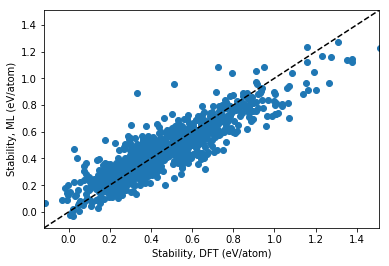

In [19]:
fig, ax = plt.subplots()

ax.scatter(test_data['class'], predictions)
print('R:', np.corrcoef(predictions, test_data['class'])[0][1])

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('Stability, DFT (eV/atom)')
ax.set_ylabel('Stability, ML (eV/atom)')

## Run the Test Several Times

In [20]:
def run_test(i, model, train_size):
    train_data, test_data = train_test_split(qh_data, train_size=train_size, test_size=test_size, random_state=i)
    
    model.fit(train_data['elems'], train_data['class'])
    test_data = test_data.copy()
    test_data['prediction'] = model.predict(test_data['elems'])
    test_data.sort_values('prediction', ascending=True, inplace=True)
    return int(sum(test_data['class'].iloc[:pick_size] <= 0)) # int() converts the answer from np.int32

In [21]:
scores = dict()
for train_size in tqdm(train_sizes, desc='Size'):
    # Tune the model
    train_data, test_data = train_test_split(qh_data, train_size=train_size, test_size=train_size)
    model.tune_and_fit(train_data['elems'], train_data['class'], test_data['elems'], test_data['class'])
    
    scores[str(train_size)] = [run_test(i, model, train_size) for i in tqdm(range(n_repeats), desc='%d Repeat'%train_size)]

HBox(children=(IntProgress(value=0, description='Size', max=4), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='1 Repeat', max=25), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='10 Repeat', max=25), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='100 Repeat', max=25), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='1000 Repeat', max=25), HTML(value='')))

In [22]:
json.dump(scores, open('faber-result.json', 'w'))

## Get MAE as function of system size

In [23]:
def get_mae(train_data, test_data):   
    # Tune the metaparameters given trainng data
    model = FaberFitter()
    if len(train_data) >= 10:
        train_train_data, train_test_data = train_test_split(train_data, test_size=0.1)
        
        model.tune_and_fit(train_train_data['elems'], train_train_data['class'],
                          train_test_data['elems'], train_test_data['class'])
    
    
    model.fit(train_data['elems'], train_data['class'])
    test_data = test_data.copy()
    test_data['prediction'] = model.predict(test_data['elems'])
    return np.mean(np.abs(test_data['prediction'] - test_data['class']))

In [24]:
test_results = {'size':[], 'mae':[]}
for rep in tqdm(range(5), desc='reps', leave=True):
    # Get a new test set from the QH compounds, store remainder as train
    pool, test = train_test_split(qh_data, test_size=1000)

    # Gradually increase size of training set
    for qh_size in tqdm(np.logspace(0, np.log10(len(pool)), 8, dtype=int), desc='size', leave=False):
        if qh_size > 3000: # KRR with >25k entries takes *a lot* of memory
            continue
        train_data = pool.sample(qh_size)
        test_results['size'].append(qh_size)
        test_results['mae'].append(get_mae(train_data, test))
test_results = pd.DataFrame(test_results)

HBox(children=(IntProgress(value=0, description='reps', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='size', max=8), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='size', max=8), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='size', max=8), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='size', max=8), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='size', max=8), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [25]:
test_results.to_csv('faber_mae.csv', index=False)